# Simple OLS regression with Gauss Markov tests

In [154]:
import matplotlib.pyplot as plt
import math
from mlxtend.plotting import plot_decision_regions
import numpy as np
from numpy import percentile
from numpy.random import seed
import os
import pandas as pd
from sqlalchemy import create_engine
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import seaborn as sns
import sklearn.datasets
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.datasets import load_breast_cancer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [155]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df0 = pd.read_sql_query('select * from houseprices', con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [156]:
nRow, nCol = df0.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1460 rows and 81 columns


In [157]:
df0.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [158]:
# Help functions to gather basic descriptions
def describe(df):
    return pd.concat([df.describe().T,
                      df.mad().rename('mean abs dev'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                      df.nunique().rename('unique')
                     ], axis=1).T

In [159]:
# Non-numerical describe
df_stat = df0.describe(include = ['O']) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198
dtype,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,object,object,object
size,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
% null,0,0,0.94,0,0,0,0,0,0,0,...,0.06,0.06,0.06,0.06,0,1,0.81,0.96,0,0


In [160]:
# Numerical describe
df_stat = df0.describe(include = [np.number]) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460,1460,1201,1460,1460,1460,1460,1460,1452,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
mean,730.5,56.8973,70.05,10516.8,6.09932,5.57534,1971.27,1984.87,103.685,443.64,...,94.2445,46.6603,21.9541,3.40959,15.061,2.7589,43.489,6.32192,2007.82,180921
std,421.61,42.3006,24.2848,9981.26,1.383,1.1128,30.2029,20.6454,181.066,456.098,...,125.339,66.256,61.1191,29.3173,55.7574,40.1773,496.123,2.70363,1.3281,79442.5
min,1,20,21,1300,1,1,1872,1950,0,0,...,0,0,0,0,0,0,0,1,2006,34900
25%,365.75,20,59,7553.5,5,5,1954,1967,0,0,...,0,0,0,0,0,0,0,5,2007,129975
50%,730.5,50,69,9478.5,6,5,1973,1994,0,383.5,...,0,25,0,0,0,0,0,6,2008,163000
75%,1095.25,70,80,11601.5,7,6,2000,2004,166,712.25,...,168,68,0,0,0,0,0,8,2009,214000
max,1460,190,313,215245,10,9,2010,2010,1600,5644,...,857,547,552,508,480,738,15500,12,2010,755000
dtype,int64,int64,float64,int64,int64,int64,int64,int64,float64,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
size,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460


## Check out columns with null values 

In [161]:
# Get a summary of null values in all the dataframe
print("No. of columns containing null values")
print(len(df0.columns[df0.isna().any()]))

print("No. of columns not containing null values")
print(len(df0.columns[df0.notna().all()]))

print("Total no. of columns in the dataframe")
print(len(df0.columns))

No. of columns containing null values
19
No. of columns not containing null values
62
Total no. of columns in the dataframe
81


In [162]:
# Get all columns with null values
nan_cols = [i for i in df0.columns if df0[i].isnull().any()]

In [163]:
# Non-numerical describe
df_stat = df0[nan_cols].describe(include = ['O']) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,alley,masvnrtype,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfintype2,electrical,fireplacequ,garagetype,garagefinish,garagequal,garagecond,poolqc,fence,miscfeature
count,91,1452,1423,1423,1422,1423,1422,1459,770,1379,1379,1379,1379,7,281,54
unique,2,4,4,4,4,6,6,5,5,6,3,5,5,3,4,4
top,Grvl,None,TA,TA,No,Unf,Unf,SBrkr,Gd,Attchd,Unf,TA,TA,Gd,MnPrv,Shed
freq,50,864,649,1311,953,430,1256,1334,380,870,605,1311,1326,3,157,49
dtype,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
size,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
% null,0.94,0.01,0.03,0.03,0.03,0.03,0.03,0,0.47,0.06,0.06,0.06,0.06,1,0.81,0.96


In [164]:
# Drop columns with many missing values
df0 = df0.drop(['alley', 'fireplacequ', 'fence', 'miscfeature'], axis=1)

In [165]:
# Get all columns with null values
nan_cols = [i for i in df0.columns if df0[i].isnull().any()]

# Numerical describe
df_stat = df0[nan_cols].describe(include = [np.number]) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,lotfrontage,masvnrarea,garageyrblt
count,1201,1452,1379
mean,70.05,103.685,1978.51
std,24.2848,181.066,24.6897
min,21,0,1900
25%,59,0,1961
50%,69,0,1980
75%,80,166,2002
max,313,1600,2010
dtype,float64,float64,float64
size,1460,1460,1460


In [166]:
# Fill NAs with mean 
df0 = df0.fillna(df0.mean())

In [167]:
# Numerical describe
df_stat = df0.describe(include = [np.number]) 
df_stat.loc['dtype'] = df0.dtypes
df_stat.loc['size'] = len(df0)
df_stat.loc['% null'] = df0.isnull().mean().round(2)
df_stat

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
mean,730.5,56.8973,70.05,10516.8,6.09932,5.57534,1971.27,1984.87,103.685,443.64,...,94.2445,46.6603,21.9541,3.40959,15.061,2.7589,43.489,6.32192,2007.82,180921
std,421.61,42.3006,22.024,9981.26,1.383,1.1128,30.2029,20.6454,180.569,456.098,...,125.339,66.256,61.1191,29.3173,55.7574,40.1773,496.123,2.70363,1.3281,79442.5
min,1,20,21,1300,1,1,1872,1950,0,0,...,0,0,0,0,0,0,0,1,2006,34900
25%,365.75,20,60,7553.5,5,5,1954,1967,0,0,...,0,0,0,0,0,0,0,5,2007,129975
50%,730.5,50,70.05,9478.5,6,5,1973,1994,0,383.5,...,0,25,0,0,0,0,0,6,2008,163000
75%,1095.25,70,79,11601.5,7,6,2000,2004,164.25,712.25,...,168,68,0,0,0,0,0,8,2009,214000
max,1460,190,313,215245,10,9,2010,2010,1600,5644,...,857,547,552,508,480,738,15500,12,2010,755000
dtype,int64,int64,float64,int64,int64,int64,int64,int64,float64,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
size,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460


## Explore and fix any outliers

In [168]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df0_num = df0.select_dtypes(include=numerics)

In [169]:
df0_num.head(2)

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 <a list of 38 Text major ticklabel objects>)

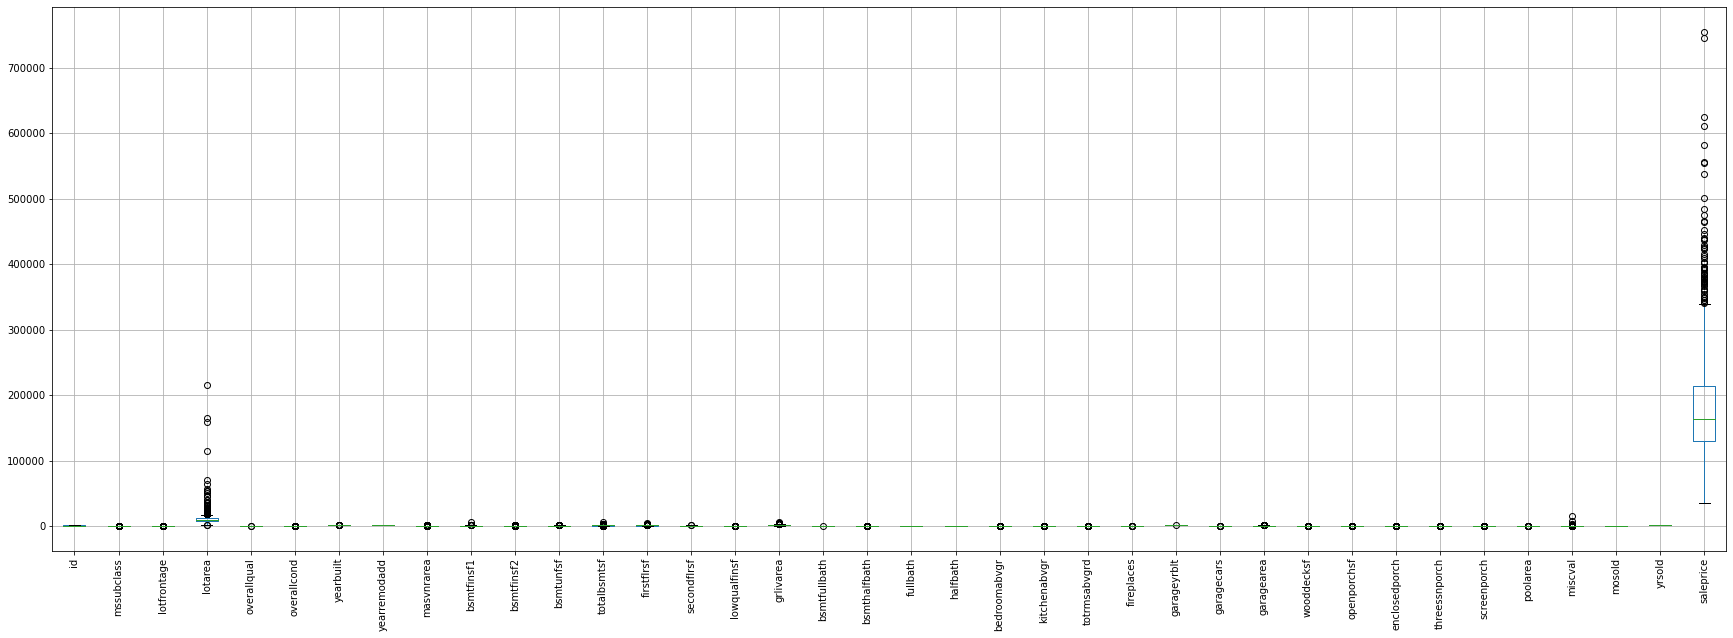

In [170]:
plt.figure(figsize = (30,10))
df0_num.boxplot()
plt.xticks(rotation=90)

In [171]:
col_dict = {c: i for i, c in enumerate(df0_num.columns, start=1)}

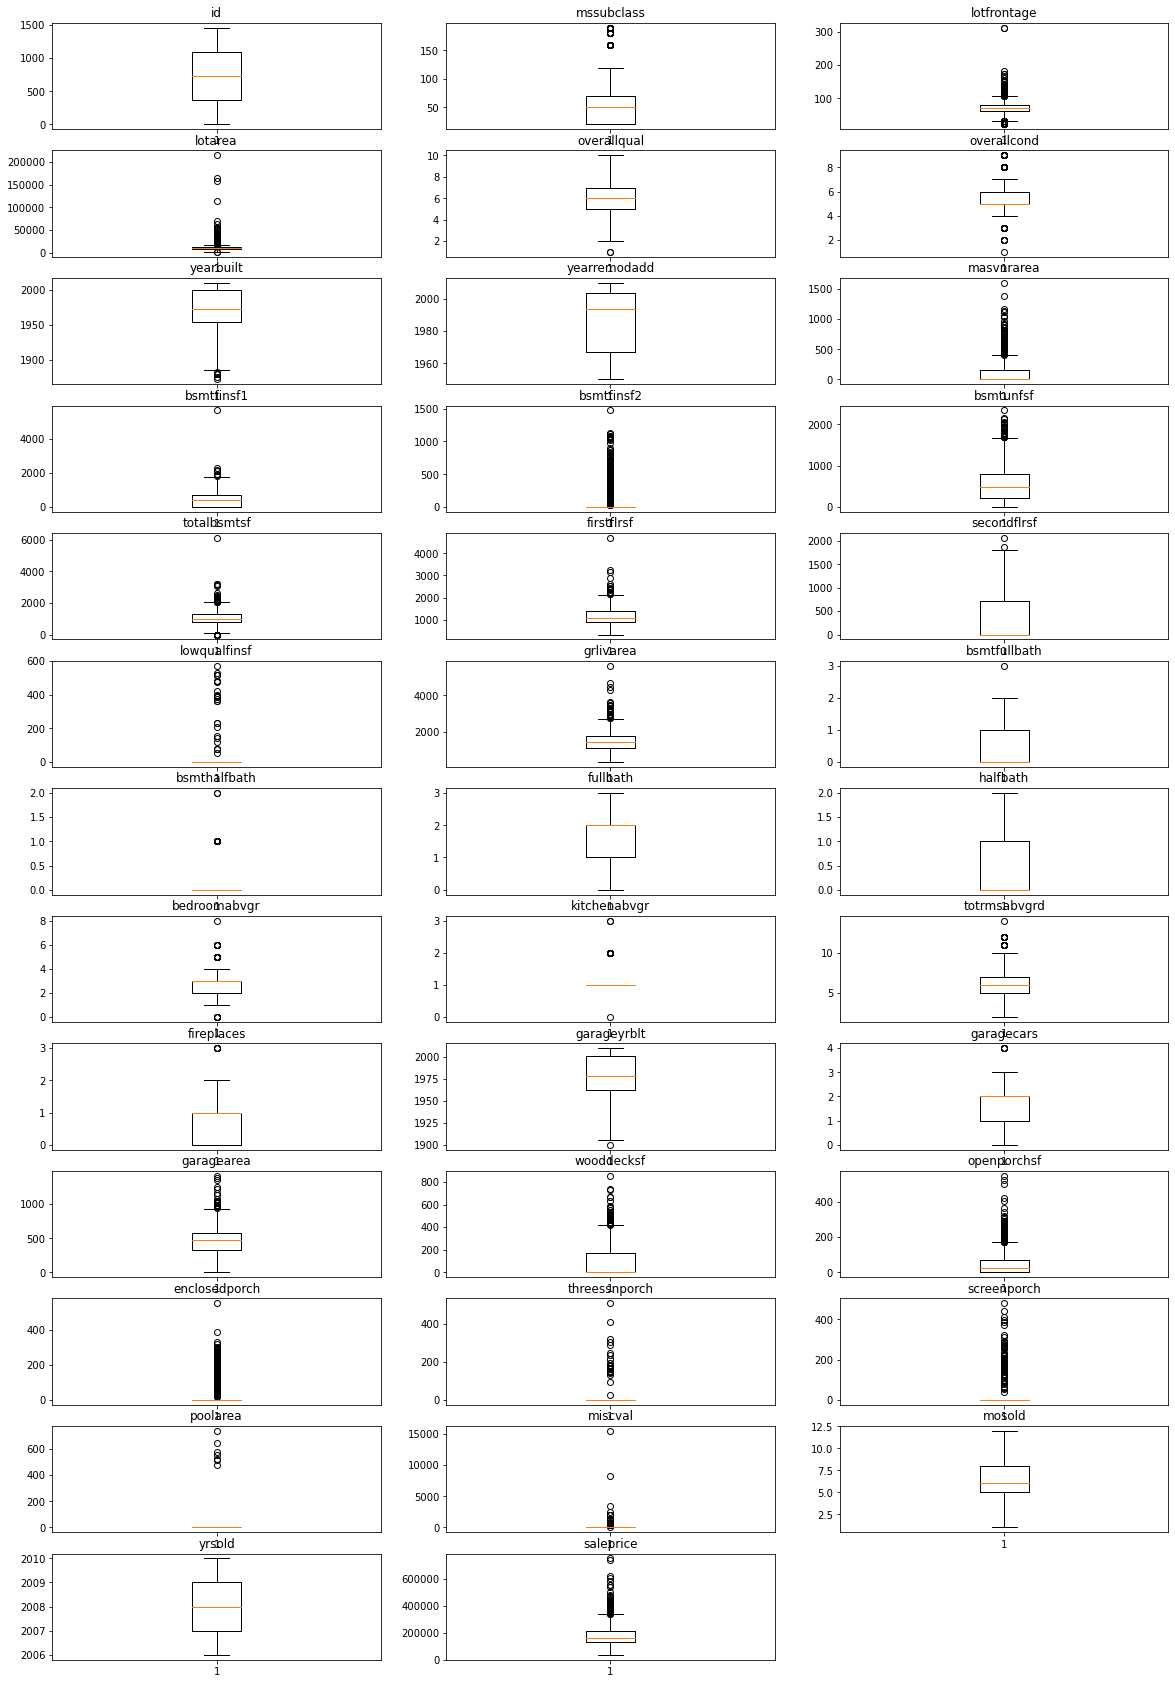

In [172]:
# Deleting outliers for each variable
# col_dict = {'Life_Expectancy':1,'Adult_Mortality':2,'Infant_Deaths':3,'Alcohol':4\
#             ,'Percentage_Exp':5,'HepatitisB':6,'Measles':7,'BMI':8,'Under_Five_Deaths':9,'Polio':10,'Tot_Exp':11\
#             ,'Diphtheria':12,'HIV/AIDS':13,'GDP':14,'Population':15,'Thinness_1to19_Years':16\
#             ,'Thinness_5to9_Years':17,'Income_Comp_of_Resources':18,'Schooling':19}


# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,70))

for variable,i in col_dict.items():
                     plt.subplot(30,3,i)
                     plt.boxplot(df0[variable],whis=1.5)
                     plt.title(variable)
plt.show()

In [173]:
q75, q25 = np.percentile(df0['lotfrontage'], [75 ,25])
iqr = q75 - q25
min_val = q25 - (iqr*1.5)
max_val = q75 + (iqr*1.5)

In [174]:
q75, q25, iqr, min_val, max_val

(79.0, 60.0, 19.0, 31.5, 107.5)

In [175]:
df0['lotfrontage'][25]

110.0

In [176]:
len(np.where(df0['lotfrontage'])[0])

1460

In [177]:
np.where(df0['lotfrontage'] < min_val)

(array([  56,   75,  146,  194,  196,  226,  228,  233,  236,  265,  364,
         431,  433,  435,  490,  501,  505,  599,  603,  614,  649,  655,
         675,  758,  764,  829,  831,  837,  914,  915,  956,  959,  962,
        1007, 1029, 1038, 1039, 1088, 1091, 1104, 1160, 1191, 1219, 1291,
        1334, 1364, 1378, 1449], dtype=int64),)

In [178]:
# Calculate number of outliers and its percentage in each variable using Tukey's method.
for variable in col_dict.keys():
    q75, q25 = np.percentile(df0[variable], [75 ,25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    col_length = len(np.where(df0[variable])[0])
    print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                len((np.where((df0[variable] > max_val) | (df0[variable] < min_val))[0])),
                                                len((np.where((df0[variable] > max_val) | (df0[variable] < min_val))[0]))*100/col_length))

Number of outliers and percentage of it in id : 0 and 0.0
Number of outliers and percentage of it in mssubclass : 103 and 7.054794520547945
Number of outliers and percentage of it in lotfrontage : 106 and 7.260273972602739
Number of outliers and percentage of it in lotarea : 69 and 4.726027397260274
Number of outliers and percentage of it in overallqual : 2 and 0.136986301369863
Number of outliers and percentage of it in overallcond : 125 and 8.561643835616438
Number of outliers and percentage of it in yearbuilt : 7 and 0.4794520547945205
Number of outliers and percentage of it in yearremodadd : 0 and 0.0
Number of outliers and percentage of it in masvnrarea : 98 and 16.360601001669448
Number of outliers and percentage of it in bsmtfinsf1 : 7 and 0.7049345417925479
Number of outliers and percentage of it in bsmtfinsf2 : 167 and 100.0
Number of outliers and percentage of it in bsmtunfsf : 29 and 2.1609538002980626
Number of outliers and percentage of it in totalbsmtsf : 61 and 4.2867182

## Winsorize outliers 

In [179]:
def using_mstats(s):
    return winsorize(s, limits=[0.01, 0.01])

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df0_num = df0.select_dtypes(include=numerics)
num_cols = df0_num.columns

df0[num_cols] = df0[num_cols].apply(lambda x: winsorize(x, limits=[0.01, 0.01]))

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 <a list of 38 Text major ticklabel objects>)

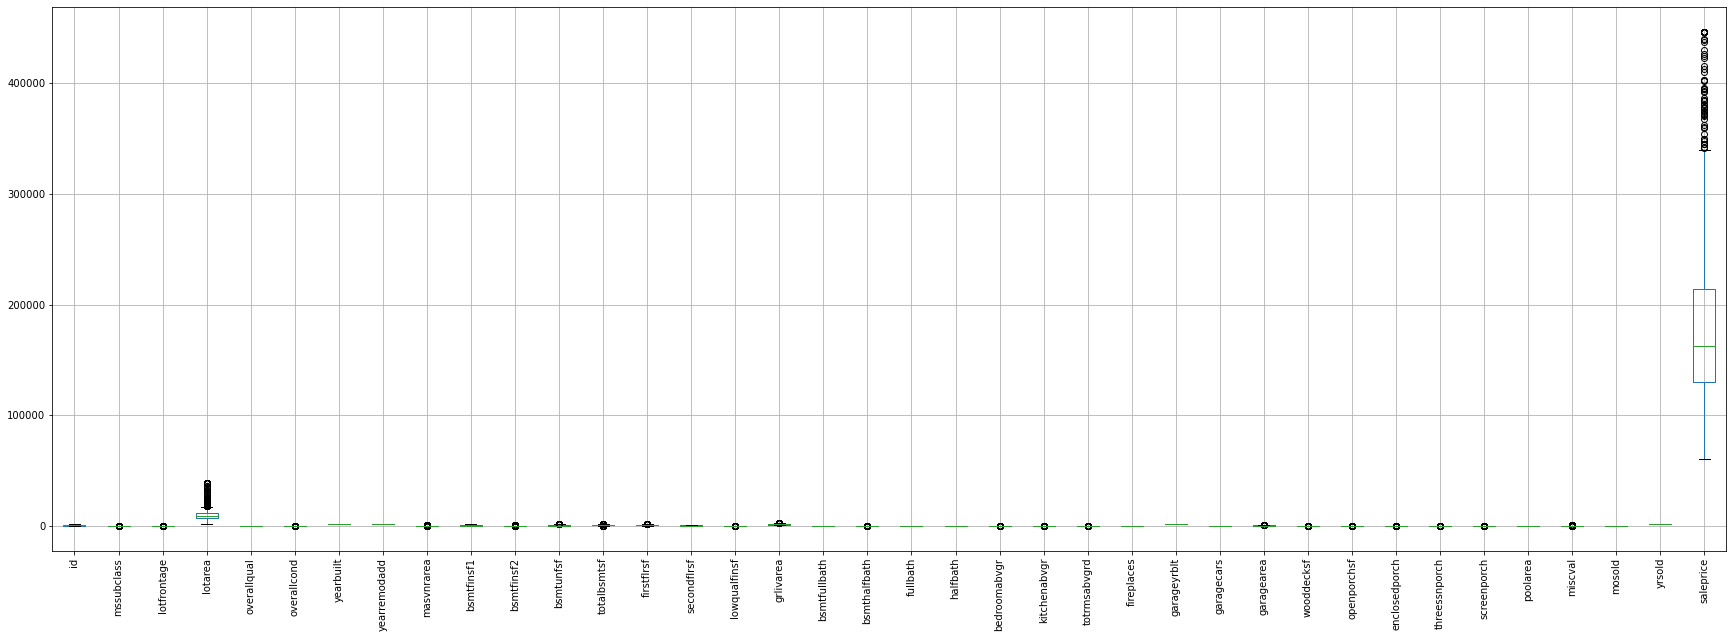

In [180]:
plt.figure(figsize = (30,10))
df0.boxplot()
plt.xticks(rotation=90)

## Add dummy variables for some categorical data 

In [181]:
df0 = df0.dropna()

In [182]:
set(df0['poolqc'])

{'Ex', 'Fa', 'Gd'}

In [183]:
set(df0['lotshape'])

{'IR1', 'IR3', 'Reg'}

In [184]:
df0 = pd.get_dummies(df0, columns=['poolqc', 'lotshape', 'garagefinish'])

In [185]:
df0.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'housestyle', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl',
       'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea', 'exterqual',
       'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
       'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf',
       'totalbsmtsf', 'heating', 'heatingqc', 'centralair', 'electrical',
       'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd', 'functional',
       'fireplaces', 'garagetype', 'garageyrblt', 'garagecars', 'garagearea',
       'garagequal', 'garagecond', 'paveddrive', 'wooddecksf', 'openporchsf',
       'enclosedporch'

In [186]:
df0.head(2)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,landcontour,utilities,lotconfig,landslope,...,saleprice,poolqc_Ex,poolqc_Fa,poolqc_Gd,lotshape_IR1,lotshape_IR3,lotshape_Reg,garagefinish_Fin,garagefinish_RFn,garagefinish_Unf
198,198,75,RL,138.0,25419,Pave,Lvl,AllPub,Corner,Gtl,...,235000,1,0,0,0,0,1,0,0,1
810,811,20,RL,78.0,10140,Pave,Lvl,AllPub,Inside,Gtl,...,181000,0,1,0,0,0,1,0,1,0


In [187]:
# Y is the target variable
Y = df0['saleprice']
# X is the feature set which includes
X = df0[['lotarea', 'poolqc_Ex', 'poolqc_Fa', 'poolqc_Gd', 'lotshape_IR1','lotshape_IR3', 'lotshape_Reg', 'garagefinish_Fin', 'garagefinish_RFn', 'garagefinish_Unf']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-1.35394194e+01  1.18266183e+05 -4.12247567e+04 -7.70414265e+04
 -2.30851469e+04  2.03880570e+05 -1.80795423e+05 -1.89283359e+04
 -4.12247567e+04  6.01530925e+04]

Intercept: 
 581534.6489686787


## Check for linearity assumption

### The way we have specified our model here supports the linearity assumption

## Check assumption that error term should be zero on average¶

In [213]:
# Y is the target variable
Y = df0['saleprice']
# X is the feature set which includes
X = df0[['lotarea', 'poolqc_Ex', 'poolqc_Fa', 'poolqc_Gd', 'lotshape_IR1','lotshape_IR3', 'lotshape_Reg', 'garagefinish_Fin', 'garagefinish_RFn', 'garagefinish_Unf']]

predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the model is: {}".format(np.mean(errors)))

Mean of the errors in the model is: 8.315380130495344e-11


### Since we have a constant term in the model, the average of the model's error is effectively zero.

## Check for the homoscedasticity assumption

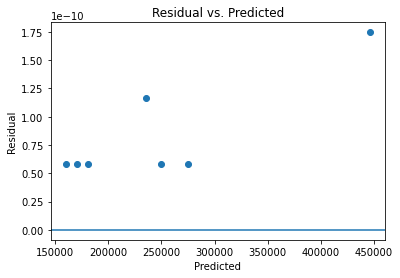

In [198]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### We can see that our error terms are consistently distributed. We do not have more variance in the error for the large outcome values than for small ones. Because of this the confidence interval for large predicted values is not biased by the average error variance.

### Perform Barlett and Levne tests

In [206]:
from scipy.stats import bartlett
from scipy.stats import levene

errors = Y - predictions
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 383.399 and p value is 2.26e-85
Levene test statistic value is 6.24121 and p value is 0.028


### The p-values of both tests are less than 0.05, meaning we can reject the null hypothesis which means our errors are hetetroscedastic. However, this could be becasue of outliers.

## Check for low multicollinearity

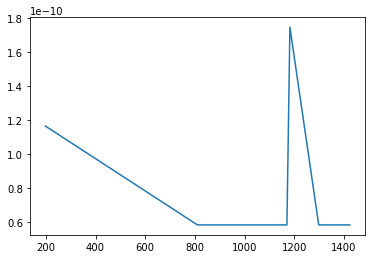

In [207]:
plt.plot(errors)
plt.show()

### It seems that the error terms of our model are correlated.

### Another option is to check the autocorrelation function. 

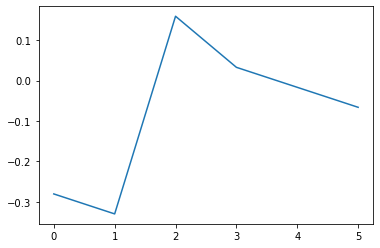

In [208]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### We have high multicollinearity violating the OLS assumptions

## Check if the features are correlated with the errors. 

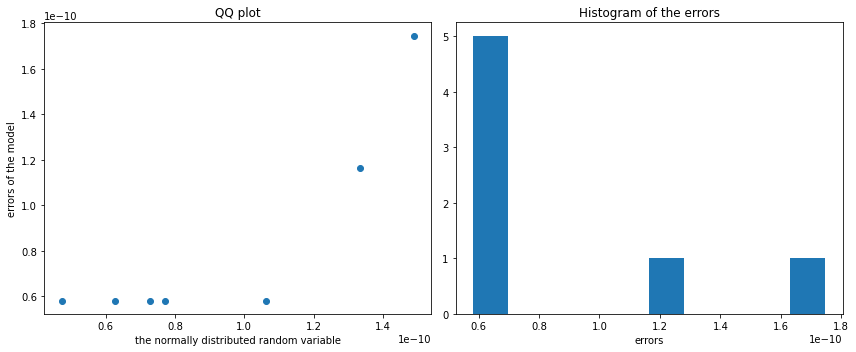

In [209]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

### Above shows that our erros are not normally distributed exactly and not far away.

### Perform Jargue Berra and normals tests

In [210]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [204]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

ValueError: skewtest is not valid with less than 8 samples; 7 samples were given.

### We cannot calculate these as there are not many errors.